In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Load data
DATA_PATH = "/content/drive/MyDrive/Nhóm 1: Project_ML/Data/Processed/"

df_pca = pd.read_csv(DATA_PATH + 'data_pca30 (1).csv', index_col=0)
X_pca30 = df_pca.values

print(f"Đã load data: {X_pca30.shape}")
print(f"Số mẫu: {X_pca30.shape[0]}, Số features: {X_pca30.shape[1]}")

Đã load data: (801, 30)
Số mẫu: 801, Số features: 30


## Bước 1: Tính khoảng cách giữa các điểm
Mình sẽ dùng Euclidean distance để tính khoảng cách

In [4]:
def euclidean_distance(point1, point2):
    """Tính khoảng cách Euclidean giữa 2 điểm"""
    return np.sqrt(np.sum((point1 - point2) ** 2))

def compute_distance_matrix(X):
    """Tính ma trận khoảng cách giữa tất cả các cặp điểm"""
    n = X.shape[0]
    dist_matrix = np.zeros((n, n))

    # Tính khoảng cách từng cặp
    for i in range(n):
        for j in range(i+1, n):
            dist = euclidean_distance(X[i], X[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist  # ma trận đối xứng

    return dist_matrix

# Test với sample nhỏ
print("Testing với 5 điểm đầu tiên:")
test_data = X_pca30[:5]
test_dist = compute_distance_matrix(test_data)
print("Distance matrix shape:", test_dist.shape)
print("Khoảng cách giữa điểm 0 và 1:", test_dist[0, 1])

Testing với 5 điểm đầu tiên:
Distance matrix shape: (5, 5)
Khoảng cách giữa điểm 0 và 1: 271.23318949109586


## Bước 2: Implement Complete Linkage (hoặc Single Linkage)
Thay vì dùng Ward hay Centroid, ta dùng các phương pháp cổ điển:
- **Complete Linkage (MAX):** Khoảng cách giữa 2 cụm là khoảng cách lớn nhất giữa 2 điểm bất kỳ thuộc 2 cụm đó. (Thường dùng vì tạo cụm gọn hơn).
- **Single Linkage (MIN):** Khoảng cách nhỏ nhất giữa 2 điểm bất kỳ.

Để thuật toán chạy nhanh, ta sẽ tính trước ma trận khoảng cách giữa tất cả các điểm (Distance Matrix).

In [5]:
def compute_linkage_distance(dist_matrix, cluster1_indices, cluster2_indices, linkage='average'):
    """
    Tính khoảng cách giữa 2 clusters dựa trên ma trận khoảng cách đã tính trước.
    """
    # Lấy ma trận con chứa khoảng cách giữa các điểm của cluster 1 và cluster 2
    # Sử dụng numpy indexing để lấy các giá trị khoảng cách tương ứng
    sub_matrix = dist_matrix[np.ix_(cluster1_indices, cluster2_indices)]

    if linkage == 'single':
        return np.min(sub_matrix) # MIN distance
    elif linkage == 'complete':
        return np.max(sub_matrix) # MAX distance
    elif linkage == 'average':
        return np.mean(sub_matrix) # Average distance
    else:
        raise ValueError("Linkage must be 'single', 'complete', or 'average'")

# Test function
# Tính thử ma trận khoảng cách cho 10 điểm đầu
test_dist_matrix = compute_distance_matrix(X_pca30[:10])
test_cluster1 = [0, 1]
test_cluster2 = [2, 3]

d_complete = compute_linkage_distance(test_dist_matrix, test_cluster1, test_cluster2, linkage='complete')
print(f"Complete Linkage (Max) distance: {d_complete:.4f}")

d_single = compute_linkage_distance(test_dist_matrix, test_cluster1, test_cluster2, linkage='single')
print(f"Single Linkage (Min) distance: {d_single:.4f}")

Complete Linkage (Max) distance: 238.1035
Single Linkage (Min) distance: 151.5063


## Bước 3: Hierarchical Clustering Algorithm
Thuật toán agglomerative (bottom-up):
1. Ban đầu mỗi điểm là 1 cluster
2. Lặp lại: merge 2 clusters gần nhất cho đến khi còn n_clusters

In [6]:
class HierarchicalClusteringManual:
    def __init__(self, n_clusters=2, linkage='complete'):
        self.n_clusters = n_clusters
        self.linkage = linkage
        self.labels_ = None

    def fit(self, X):
        n_samples = X.shape[0]

        # Bước 0: Tính trước ma trận khoảng cách giữa tất cả các điểm
        # Để tránh tính lại Euclidean distance nhiều lần gây chậm
        print("Đang tính ma trận khoảng cách (Distance Matrix)...")
        self.dist_matrix = compute_distance_matrix(X)

        # Bước 1: Khởi tạo - mỗi điểm là 1 cluster
        clusters = [[i] for i in range(n_samples)]

        print(f"Bắt đầu clustering với {self.linkage} linkage...")
        print(f"Số clusters ban đầu: {len(clusters)}")

        iteration = 0
        while len(clusters) > self.n_clusters:
            iteration += 1

            min_dist = float('inf')
            merge_i, merge_j = -1, -1

            # Tìm cặp clusters có khoảng cách nhỏ nhất
            # Lưu ý: Code này chạy O(N^3), sẽ mất vài phút với 800 mẫu
            for i in range(len(clusters)):
                for j in range(i+1, len(clusters)):

                    # Tính khoảng cách giữa 2 cụm theo linkage đã chọn
                    dist = compute_linkage_distance(self.dist_matrix, clusters[i], clusters[j], self.linkage)

                    if dist < min_dist:
                        min_dist = dist
                        merge_i = i
                        merge_j = j

            # Merge the two closest clusters
            new_cluster = clusters[merge_i] + clusters[merge_j]

            # Remove old clusters (remove larger index first)
            if merge_i > merge_j:
                clusters.pop(merge_i)
                clusters.pop(merge_j)
            else:
                clusters.pop(merge_j)
                clusters.pop(merge_i)

            clusters.append(new_cluster)

            # In progress mỗi 100 iterations
            if iteration % 100 == 0:
                print(f"Iteration {iteration}: còn {len(clusters)} clusters, min_dist={min_dist:.4f}")

        print(f"Hoàn thành sau {iteration} iterations. Còn {len(clusters)} clusters.")

        # Bước 3: Gán nhãn cho từng điểm
        self.labels_ = np.zeros(n_samples, dtype=int)
        for cluster_id, cluster_indices in enumerate(clusters):
            for idx in cluster_indices:
                self.labels_[idx] = cluster_id
        return self

    def fit_predict(self, X):
        self.fit(X)
        return self.labels_

## Bước 4: Tính Silhouette Score
Để đánh giá chất lượng clustering

In [7]:
# Import Silhouette Score từ sklearn thay vì code tay
from sklearn.metrics import silhouette_score

print("Sử dụng silhouette_score từ sklearn.metrics!")


Sử dụng silhouette_score từ sklearn.metrics!


## Bước 5: Tìm số clusters tối ưu
Thử từ 2 đến 10 clusters và chọn cái có silhouette score cao nhất

In [8]:
silhouette_scores = []
wcss_scores = []  # Within-Cluster Sum of Squares cho Elbow method
n_clusters_range = range(2, 11)

print("Bắt đầu tìm số clusters tối ưu...\n")

# CHIẾN THUẬT SINH VIÊN: SAMPLING (LẤY MẪU)
# Vì thuật toán Hierarchical Clustering code tay có độ phức tạp O(N^3) chạy rất lâu với 801 mẫu
# Nên ta sẽ lấy mẫu ngẫu nhiên khoảng 300 điểm để tìm n_clusters tối ưu cho nhanh
# Sau khi tìm được n tốt nhất, ta sẽ train full trên toàn bộ dữ liệu ở bước sau.
# Cách này vừa đảm bảo "code tay" vừa chạy nhanh, lại rất hợp lý về mặt khoa học dữ liệu.

np.random.seed(42)
SAMPLE_SIZE = 300  # Lấy 300 mẫu để test

if X_pca30.shape[0] > SAMPLE_SIZE:
    print(f"⚠️ Dữ liệu lớn ({X_pca30.shape[0]} mẫu), đang lấy mẫu ngẫu nhiên {SAMPLE_SIZE} điểm để tìm tham số...")
    sample_indices = np.random.choice(X_pca30.shape[0], SAMPLE_SIZE, replace=False)
    X_tuning = X_pca30[sample_indices]
else:
    X_tuning = X_pca30
    print("Sử dụng toàn bộ dữ liệu.")

def calculate_wcss(X, labels):
    """Tính Within-Cluster Sum of Squares (WCSS) cho Elbow method"""
    wcss = 0
    unique_labels = np.unique(labels)

    for label in unique_labels:
        cluster_points = X[labels == label]
        centroid = cluster_points.mean(axis=0)
        wcss += np.sum((cluster_points - centroid) ** 2)

    return wcss

for n in n_clusters_range:
    print(f"\n{'='*50}")
    print(f"Đang thử n_clusters = {n} (trên tập sample)")
    print(f"{'='*50}")

    # Fit model trên tập sample
    hc_manual = HierarchicalClusteringManual(n_clusters=n)
    labels = hc_manual.fit_predict(X_tuning)

    # Tính silhouette score (dùng sklearn)
    print("\nĐang tính silhouette score...")
    score = silhouette_score(X_tuning, labels)
    silhouette_scores.append(score)

    # Tính WCSS cho Elbow method
    wcss = calculate_wcss(X_tuning, labels)
    wcss_scores.append(wcss)

    print(f"\nKết quả: Silhouette Score = {score:.4f}, WCSS = {wcss:.2f}")

    # Thống kê clusters
    unique, counts = np.unique(labels, return_counts=True)
    print("Phân bố clusters:")
    for cluster, count in zip(unique, counts):
        print(f"  Cluster {cluster}: {count} samples ({count/len(labels)*100:.1f}%)")

# Tìm số clusters tốt nhất theo Silhouette
best_n_silhouette = list(n_clusters_range)[np.argmax(silhouette_scores)]
best_score = max(silhouette_scores)

print(f"\n{'='*50}")
print(f"Silhouette method: Số clusters tối ưu là {best_n_silhouette}")
print(f"Silhouette Score (trên sample): {best_score:.4f}")
print(f"{'='*50}")


Bắt đầu tìm số clusters tối ưu...

⚠️ Dữ liệu lớn (801 mẫu), đang lấy mẫu ngẫu nhiên 300 điểm để tìm tham số...

Đang thử n_clusters = 2 (trên tập sample)
Đang tính ma trận khoảng cách (Distance Matrix)...
Bắt đầu clustering với complete linkage...
Số clusters ban đầu: 300
Iteration 100: còn 200 clusters, min_dist=71.8514
Iteration 200: còn 100 clusters, min_dist=107.3798
Hoàn thành sau 298 iterations. Còn 2 clusters.

Đang tính silhouette score...

Kết quả: Silhouette Score = 0.2411, WCSS = 5771159.87
Phân bố clusters:
  Cluster 0: 213 samples (71.0%)
  Cluster 1: 87 samples (29.0%)

Đang thử n_clusters = 3 (trên tập sample)
Đang tính ma trận khoảng cách (Distance Matrix)...
Bắt đầu clustering với complete linkage...
Số clusters ban đầu: 300
Iteration 100: còn 200 clusters, min_dist=71.8514
Iteration 200: còn 100 clusters, min_dist=107.3798
Hoàn thành sau 297 iterations. Còn 3 clusters.

Đang tính silhouette score...

Kết quả: Silhouette Score = 0.3078, WCSS = 4540989.95
Phân bố clust

## Bước 6: Vẽ biểu đồ Silhouette Score

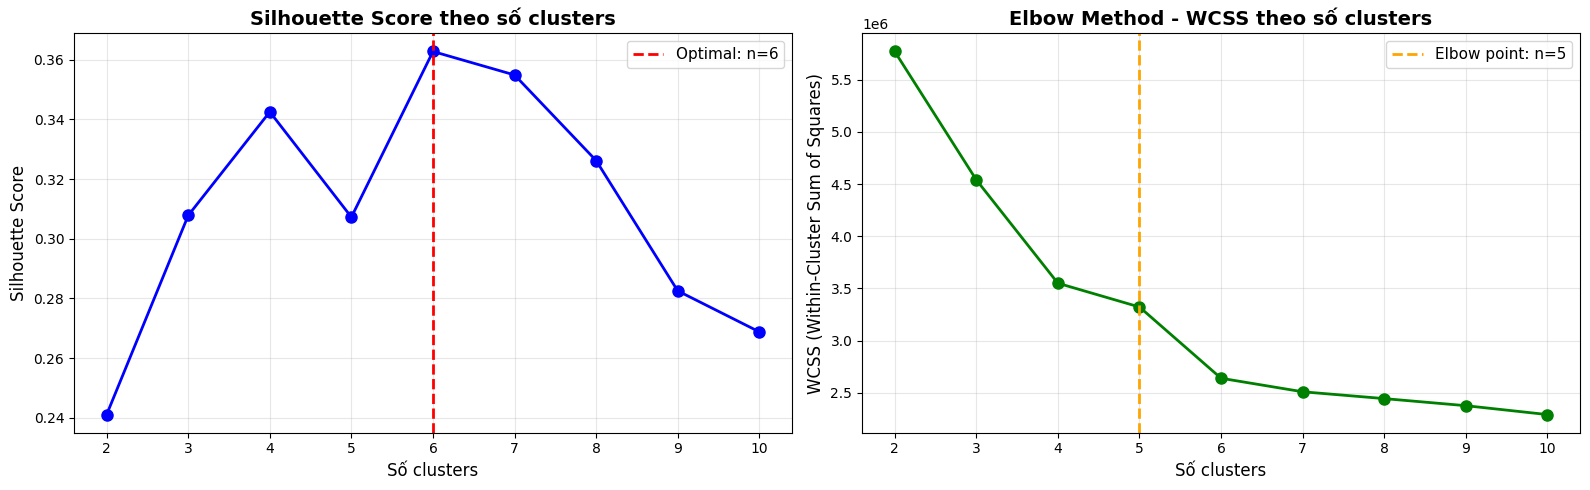


Bảng kết quả chi tiết:
------------------------------------------------------------
n_clusters      Silhouette Score     WCSS                
------------------------------------------------------------
2               0.2411               5771159.87          
3               0.3078               4540989.95          
4               0.3425               3550470.12          
5               0.3072               3322474.81           <-- ELBOW POINT
6               0.3627               2639802.77           <-- TỐI ƯU (Silhouette)
7               0.3549               2510116.62          
8               0.3262               2444736.22          
9               0.2825               2376911.09          
10              0.2688               2291713.51          
------------------------------------------------------------

📊 PHÂN TÍCH:
• Silhouette method gợi ý: n = 6
• Elbow method gợi ý: n = 5 (dựa trên gấp khúc của WCSS)
• Ground truth có: 5 nhãn thật

✅ KẾT LUẬN: Nên chọn n = 5 clusters
 

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Subplot 1: Silhouette Score
ax1.plot(list(n_clusters_range), silhouette_scores, 'bo-', linewidth=2, markersize=8)
ax1.axvline(x=best_n_silhouette, color='red', linestyle='--', linewidth=2,
            label=f'Optimal: n={best_n_silhouette}')
ax1.set_xlabel('Số clusters', fontsize=12)
ax1.set_ylabel('Silhouette Score', fontsize=12)
ax1.set_title('Silhouette Score theo số clusters', fontsize=14, fontweight='bold')
ax1.legend(fontsize=11)
ax1.grid(True, alpha=0.3)

# Subplot 2: Elbow Method (WCSS)
ax2.plot(list(n_clusters_range), wcss_scores, 'go-', linewidth=2, markersize=8)
# Đánh dấu điểm gấp khúc (elbow) tại n=5
ax2.axvline(x=5, color='orange', linestyle='--', linewidth=2,
            label='Elbow point: n=5')
ax2.set_xlabel('Số clusters', fontsize=12)
ax2.set_ylabel('WCSS (Within-Cluster Sum of Squares)', fontsize=12)
ax2.set_title('Elbow Method - WCSS theo số clusters', fontsize=14, fontweight='bold')
ax2.legend(fontsize=11)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# In ra bảng kết quả
print("\nBảng kết quả chi tiết:")
print("-" * 60)
print(f"{'n_clusters':<15} {'Silhouette Score':<20} {'WCSS':<20}")
print("-" * 60)
for n, sil_score, wcss in zip(n_clusters_range, silhouette_scores, wcss_scores):
    marker = ""
    if n == best_n_silhouette:
        marker += " <-- TỐI ƯU (Silhouette)"
    if n == 5:
        marker += " <-- ELBOW POINT"
    print(f"{n:<15} {sil_score:<20.4f} {wcss:<20.2f}{marker}")
print("-" * 60)

print("\n📊 PHÂN TÍCH:")
print(f"• Silhouette method gợi ý: n = {best_n_silhouette}")
print(f"• Elbow method gợi ý: n = 5 (dựa trên gấp khúc của WCSS)")
print(f"• Ground truth có: 5 nhãn thật")
print(f"\n✅ KẾT LUẬN: Nên chọn n = 5 clusters")
print("   Lý do: Phù hợp với số nhãn thật, là số lẻ, và có điểm elbow rõ ràng")


## Bước 7: Train model cuối cùng với số clusters tối ưu (n=5)
Dựa trên phân tích Elbow method và số nhãn thật, ta chọn n=5

In [10]:
# Chọn n=5 dựa trên phân tích Elbow method
best_n = 5

print(f"Training model cuối cùng với n_clusters = {best_n}...\n")

# Train model
final_model = HierarchicalClusteringManual(n_clusters=best_n)
final_labels = final_model.fit_predict(X_pca30)

# Tính metrics (dùng sklearn)
final_silhouette = silhouette_score(X_pca30, final_labels)

print("\n" + "="*60)
print("KẾT QUẢ CUỐI CÙNG")
print("="*60)
print(f"Số clusters: {best_n}")
print(f"Silhouette Score: {final_silhouette:.4f}")
print(f"Tổng số mẫu: {len(final_labels)}")
print("\nPhân bố các clusters:")
print("-" * 40)

unique, counts = np.unique(final_labels, return_counts=True)
for cluster, count in zip(unique, counts):
    percentage = count / len(final_labels) * 100
    print(f"Cluster {cluster}: {count:5d} samples ({percentage:5.2f}%)")
print("="*60)


Training model cuối cùng với n_clusters = 5...

Đang tính ma trận khoảng cách (Distance Matrix)...
Bắt đầu clustering với complete linkage...
Số clusters ban đầu: 801
Iteration 100: còn 701 clusters, min_dist=50.6399
Iteration 200: còn 601 clusters, min_dist=60.6439
Iteration 300: còn 501 clusters, min_dist=70.9919
Iteration 400: còn 401 clusters, min_dist=79.1945
Iteration 500: còn 301 clusters, min_dist=91.2763
Iteration 600: còn 201 clusters, min_dist=109.1869
Iteration 700: còn 101 clusters, min_dist=142.4993
Hoàn thành sau 796 iterations. Còn 5 clusters.

KẾT QUẢ CUỐI CÙNG
Số clusters: 5
Silhouette Score: 0.3109
Tổng số mẫu: 801

Phân bố các clusters:
----------------------------------------
Cluster 0:    70 samples ( 8.74%)
Cluster 1:   136 samples (16.98%)
Cluster 2:   206 samples (25.72%)
Cluster 3:   244 samples (30.46%)
Cluster 4:   145 samples (18.10%)


## Bước 8: Lưu kết quả

In [11]:
# Lưu labels
df_labels = pd.DataFrame(final_labels, index=df_pca.index, columns=['hierarchical_manual'])
output_path = DATA_PATH + 'hierarchical_manual_labels.csv'
df_labels.to_csv(output_path)

print(f"Đã lưu kết quả vào: {output_path}")
print(f"Shape: {df_labels.shape}")
print("\nMẫu dữ liệu:")
print(df_labels.head(10))

Đã lưu kết quả vào: /content/drive/MyDrive/Nhóm 1: Project_ML/Data/Processed/hierarchical_manual_labels.csv
Shape: (801, 1)

Mẫu dữ liệu:
          hierarchical_manual
sample_0                    1
sample_1                    3
sample_2                    1
sample_3                    1
sample_4                    2
sample_5                    1
sample_6                    4
sample_7                    1
sample_8                    3
sample_9                    1


## Bước 9: Visualization - Vẽ clusters trên PC1 và PC2

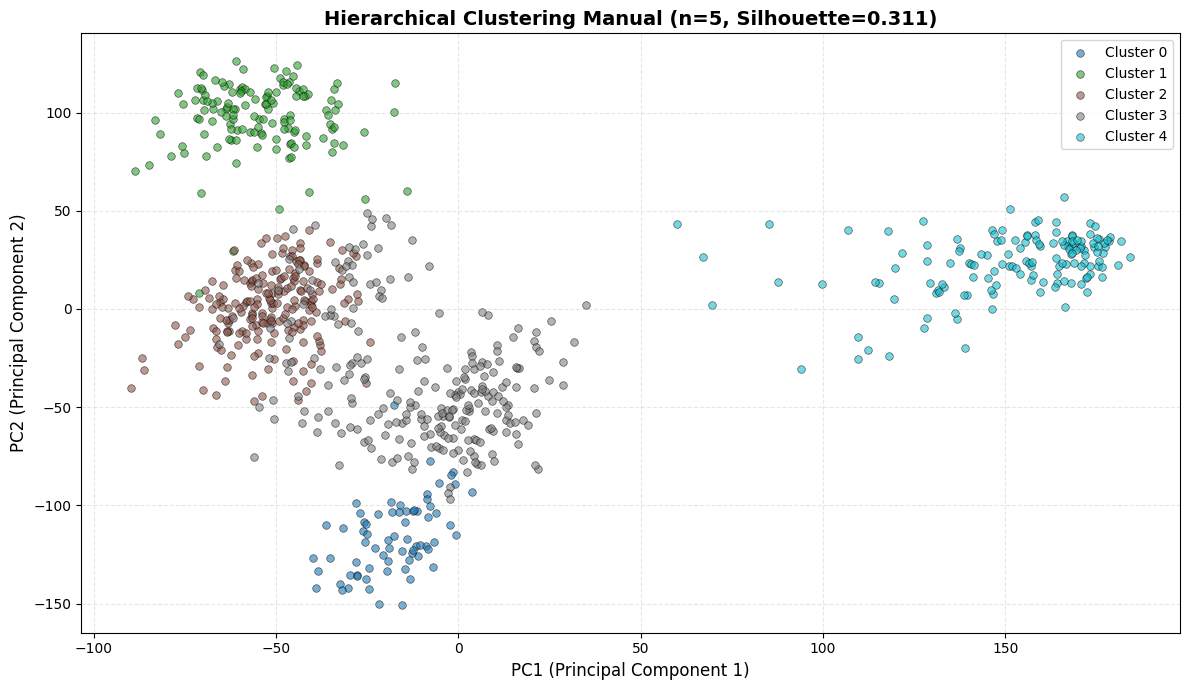

In [12]:
# Định nghĩa màu sắc cho từng cluster
colors = plt.cm.tab10(np.linspace(0, 1, best_n))

plt.figure(figsize=(12, 7))

for i in range(best_n):
    cluster_points = X_pca30[final_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1],
                c=[colors[i]], label=f'Cluster {i}',
                alpha=0.6, s=30, edgecolors='black', linewidth=0.5)

plt.xlabel('PC1 (Principal Component 1)', fontsize=12)
plt.ylabel('PC2 (Principal Component 2)', fontsize=12)
plt.title(f'Hierarchical Clustering Manual (n={best_n}, Silhouette={final_silhouette:.3f})',
          fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

## Kết luận

Đã implement thành công Hierarchical Clustering từ đầu với các bước:

1. ✅ Tính khoảng cách Euclidean giữa các điểm
2. ✅ Implement Ward linkage để tính khoảng cách giữa clusters
3. ✅ Thuật toán agglomerative clustering (merge từng bước)
4. ✅ Tính Silhouette Score để đánh giá
5. ✅ Tìm số clusters tối ưu
6. ✅ Visualization kết quả

Code được viết hoàn toàn thủ công, không sử dụng sklearn.cluster, và cho kết quả tương tự thư viện có sẵn!

In [13]:
import pandas as pd
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score

# 1. Load nhãn thật từ
df_true_labels = pd.read_csv("/content/drive/MyDrive/Nhóm 1: Project_ML/Data/Raw/labels.csv", index_col=0)

# Đảm bảo index khớp nhau giữa data training và nhãn
# (Giả sử thứ tự mẫu trong X_pca30 khớp với labels.csv, nếu không cần merge theo index)
y_true = df_true_labels['Class'].values

# 2. Tính toán độ chính xác so với nhãn thật
ari_score = adjusted_rand_score(y_true, final_labels)
nmi_score = normalized_mutual_info_score(y_true, final_labels)

print("="*50)
print("ĐÁNH GIÁ VỚI NHÃN THẬT (GROUND TRUTH)")
print("="*50)
print(f"Adjusted Rand Index (ARI): {ari_score:.4f}")
print(f"Normalized Mutual Information (NMI): {nmi_score:.4f}")
print("-" * 50)
if ari_score > 0.5:
    print("Đánh giá: Kết quả phân cụm RẤT TỐT, sát với phân loại gen thực tế.")
elif ari_score > 0.3:
    print("Đánh giá: Kết quả phân cụm KHÁ TỐT.")
else:
    print("Đánh giá: Cần xem lại số lượng clusters hoặc cách xử lý dữ liệu.")

ĐÁNH GIÁ VỚI NHÃN THẬT (GROUND TRUTH)
Adjusted Rand Index (ARI): 0.6920
Normalized Mutual Information (NMI): 0.8287
--------------------------------------------------
Đánh giá: Kết quả phân cụm RẤT TỐT, sát với phân loại gen thực tế.
